# Snake

Same but using eligibility trace for the gradient

In [237]:
from helpers import re_normalize_possible_actions
from environments import *
import tensorflow as tf
from datetime import datetime
import numpy as np
from  tqdm import trange
import matplotlib.pyplot as plt

## Environment definition

In [224]:
BOARD_SIZE=5

In [238]:
def get_models():
    # region models
    input = K.layers.Input(shape=(BOARD_SIZE, BOARD_SIZE, 3))
    x = K.layers.Conv2D(64, (3, 3), padding="SAME", activation="linear", use_bias=False)(input)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation(tf.nn.leaky_relu)(x)

    x = K.layers.Conv2D(64, (3, 3), padding="SAME", activation="linear", use_bias=False)(x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation(tf.nn.leaky_relu)(x)

    x = K.layers.Conv2D(64, (3, 3), padding="SAME", activation="linear", use_bias=False)(x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation(tf.nn.leaky_relu)(x)

    x = K.layers.MaxPool2D(2)(x)

    x = K.layers.Conv2D(64, (2, 2), padding="SAME", activation="linear", use_bias=False)(x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation(tf.nn.leaky_relu)(x)

    x = K.layers.Conv2D(64, (2, 2), padding="SAME", activation="linear", use_bias=False)(x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation(tf.nn.leaky_relu)(x)

    x = K.layers.Conv2D(8, (2, 2), padding="SAME", activation="linear", use_bias=False)(x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation(tf.nn.leaky_relu)(x)

    x = K.layers.GlobalAvgPool2D()(x)

    policy = K.layers.Dense(64, activation=tf.nn.leaky_relu)(x)
    policy = K.layers.Dense(64, activation=tf.nn.leaky_relu)(policy)
    policy = K.layers.Dense(4, activation=tf.nn.softmax)(policy)
    agent = K.models.Model(inputs=input, outputs=policy)




    input = K.layers.Input(shape=(BOARD_SIZE, BOARD_SIZE, 3))
    x = K.layers.Conv2D(64, (3, 3), padding="SAME", activation="linear", use_bias=False)(input)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation(tf.nn.leaky_relu)(x)

    x = K.layers.Conv2D(64, (3, 3), padding="SAME", activation="linear", use_bias=False)(x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation(tf.nn.leaky_relu)(x)

    x = K.layers.Conv2D(64, (3, 3), padding="SAME", activation="linear", use_bias=False)(x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation(tf.nn.leaky_relu)(x)

    x = K.layers.MaxPool2D(2)(x)

    x = K.layers.Conv2D(64, (2, 2), padding="SAME", activation="linear", use_bias=False)(x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation(tf.nn.leaky_relu)(x)

    x = K.layers.Conv2D(64, (2, 2), padding="SAME", activation="linear", use_bias=False)(x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation(tf.nn.leaky_relu)(x)

    x = K.layers.Conv2D(8, (2, 2), padding="SAME", activation="linear", use_bias=False)(x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation(tf.nn.leaky_relu)(x)

    x = K.layers.GlobalAvgPool2D()(x)

    vf = K.layers.Dense(64, activation=tf.nn.leaky_relu)(x)
    vf = K.layers.Dense(64, activation=tf.nn.leaky_relu)(vf)
    vf = K.layers.Dense(1, activation="linear")(vf)
    value = K.models.Model(inputs=input, outputs=vf)
    return agent, value

In [226]:
LAMBDA_AGENT = 0.5
LAMBDA_VALUE = 0.5

In [197]:
try:
    last_model_trained = sorted([
        f.path for f in os.scandir(f'models_eligibility_trace/{BOARD_SIZE}x{BOARD_SIZE}-{LAMBDA_AGENT}-{LAMBDA_VALUE}/')
        if f.is_dir()
    ])[-1]
    agent.load_weights(last_model_trained+f"/agent")
    value.load_weights(last_model_trained+f"/value")
    print("loaded")
except:
    pass

loaded


## Training

In [239]:
env_ = NumpyEnvironment(1000, BOARD_SIZE)
env_.FRUIT_REWARD = .5
env_.ATE_HIMSELF_REWARD = .2
env_.WIN_REWARD = 1.
env_.STEP_REWARD = 0.

GAMMA = .99

ITERATIONS = 10000
EPSILON = 0.05

In [240]:
optimizer_value = K.optimizers.Adam(1e-3)
optimizer_agent = K.optimizers.Adam(1e-5)

In [242]:
avg_rewards = {}

In [235]:
try :
    import json
    with open(f"models_eligibility_trace_fitting/trend_{BOARD_SIZE}x{BOARD_SIZE}.txt", "r") as file:
        t = json.load(file)
    print("loaded")
except:
    pass

loaded


In [243]:
for LAMBDA_VALUE, LAMBDA_AGENT in [(0.01, 0.01), (0.1, 0.1), (0.5, 0.5), (0.9,0.9)]:
    agent, value = get_models()
    I = 1
    eligibility_trace_agent = [tf.zeros_like(layer) for layer in agent.trainable_weights]
    eligibility_trace_value = [tf.zeros_like(layer) for layer in value.trainable_weights]
    for iterations in trange(ITERATIONS):
        state = env_.to_state()

        with tf.GradientTape(persistent=True) as tape:
            # calculate distributions of actions
            original_probs = agent(
                state
            )
            # remove actions that are not available
            probs = re_normalize_possible_actions(
                state,
                original_probs + EPSILON
            )
            # sample actions
            actions = tf.random.categorical(tf.math.log(tf.stop_gradient(probs)), 1, dtype=tf.int32)

            # MDP update
            # print("start move")
            rewards = env_.move(actions)
            # print("end move")
            new_state = env_.to_state()

            # TD error
            value_state = value(state)
            td_error = tf.stop_gradient((rewards + GAMMA * value(new_state, training=False)) - value_state) * -1  # to do gradient ascend

            # calculate the loss for both value and agent
            actions_indexes = tf.concat((tf.range(actions.shape[0])[..., None], actions), axis=-1)

            # maybe introduce eligibility trace to simulate n-step td, to have longer dependencies
            loss_agent = tf.stop_gradient(td_error) * tf.math.log(1e-10 + tf.gather_nd(probs, actions_indexes))[...,None]
            loss_value = tf.stop_gradient(td_error) * value_state

            loss_agent = tf.reduce_mean(loss_agent)
            loss_value = tf.reduce_mean(loss_value)

        # calculate gradient
        gradient_agent = tape.gradient(loss_agent, agent.trainable_weights)
        gradient_value = tape.gradient(loss_value, value.trainable_weights)

        if f"{LAMBDA_AGENT}-{LAMBDA_VALUE}" not in avg_rewards.keys():
            avg_rewards[f"{LAMBDA_AGENT}-{LAMBDA_VALUE}"] = []

        avg_rewards[f"{LAMBDA_AGENT}-{LAMBDA_VALUE}"].append(tf.reduce_mean(rewards))

        # update neural nets weights
        eligibility_trace_agent = [GAMMA * LAMBDA_AGENT * layer + I * gradient for layer, gradient in zip(eligibility_trace_agent, gradient_agent)]
        eligibility_trace_value = [GAMMA * LAMBDA_VALUE * layer + I * gradient for layer, gradient in zip(eligibility_trace_value, gradient_value)]
        optimizer_agent.apply_gradients(zip(eligibility_trace_agent, agent.trainable_weights))
        optimizer_value.apply_gradients(zip(eligibility_trace_value, value.trainable_weights))

        #I = GAMMA * I

        if iterations % 1000 == 0:
            now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            agent.save_weights(f"models_eligibility_trace/{BOARD_SIZE}x{BOARD_SIZE}-{LAMBDA_AGENT}-{LAMBDA_VALUE}/{now}/agent")
            value.save_weights(f"models_eligibility_trace/{BOARD_SIZE}x{BOARD_SIZE}-{LAMBDA_AGENT}-{LAMBDA_VALUE}/{now}/value")


100%|██████████| 10000/10000 [10:44<00:00, 15.51it/s]


In [244]:
import json
with open(f"models_eligibility_trace_fitting/trend_{BOARD_SIZE}x{BOARD_SIZE}.txt", "w+") as file:
    avg_rewards = {k:np.array(v).tolist() for k, v in avg_rewards.items()}
    json.dump(avg_rewards, file)

### Random policy reward

In [245]:
random_env_ = NumpyEnvironment(1000, BOARD_SIZE)
random_env_.FRUIT_REWARD = .5
random_env_.ATE_HIMSELF_REWARD = .2
random_env_.WIN_REWARD = 1.
random_env_.STEP_REWARD = 0.
random_rewards = []

for _ in trange(100):
    state = random_env_.to_state()
    probs = re_normalize_possible_actions(
        state,
        tf.repeat([[.25]*4],1000, axis=0)
    )
    #sample actions
    actions =  tf.random.categorical(tf.math.log(probs), 1, dtype=tf.int32)

    # MDP update
    rewards = random_env_.move(actions)
    random_rewards.append(tf.reduce_mean(rewards))

100%|██████████| 100/100 [00:01<00:00, 79.02it/s]


## Training evaluation

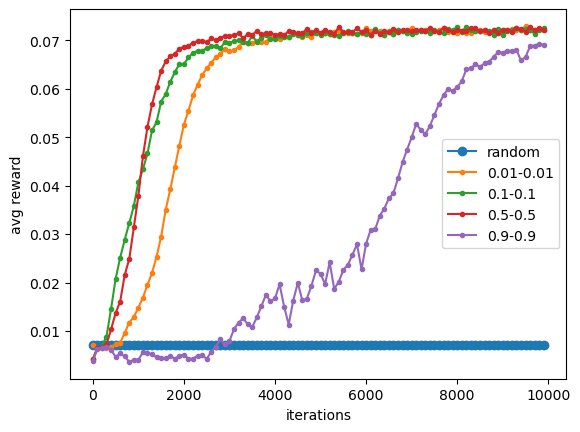

In [246]:
%matplotlib inline

CHUNK_SIZE = 100
N = min([len(el)//CHUNK_SIZE*CHUNK_SIZE for el in avg_rewards.values()])
x = np.arange(0,N//CHUNK_SIZE)*CHUNK_SIZE
plt.plot(x, np.array(random_rewards).mean(axis=-1).repeat(N//CHUNK_SIZE), marker="o")
for trend in avg_rewards.values():
    points = np.array(trend)[:N].reshape((-1, CHUNK_SIZE)).mean(axis=-1)
    plt.plot(x, points, marker=".")
_ = plt.xlabel("iterations")
_ = plt.ylabel("avg reward")
plt.legend(["random"] + list(avg_rewards.keys()))